# Asset Pricing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import quantecon as qe

## Generate a Markov process with raw code

In [3]:
from scipy.stats import binom

In [4]:
P = np.array([[0.85, 0.15],[0.65, 0.35]])

In [5]:
P

array([[0.85, 0.15],
       [0.65, 0.35]])

In [8]:
def mc_sample(P,size=1000):
    X = np.empty(size,dtype=int)
    X[0] = 0
    for t in range(size-1):
        if X[t] == 1:
            X[t+1] = binom.rvs(1,P[0,0])
        else:
            X[t+1] = binom.rvs(1,P[1,0])
    return X

In [9]:
X = mc_sample(P,size=1000_000)

In [10]:
X

array([0, 0, 1, ..., 1, 1, 1])

In [11]:
np.mean(X==1)

0.813159

## Using `quantecon`

In [12]:
mc = qe.MarkovChain(P)

In [13]:
X = mc.simulate(ts_length=1000_000)

In [14]:
np.mean(X==1)

0.18693

In [15]:
mc.stationary_distributions

array([[0.8125, 0.1875]])

## Simulate dividend growth

In [16]:
mc = qe.MarkovChain(P, state_values=(1.03,0.94))

In [17]:
sim_length = 80
g_series = mc.simulate(ts_length=sim_length)
d_series = np.cumprod(g_series) # Assumes d_0 = 1

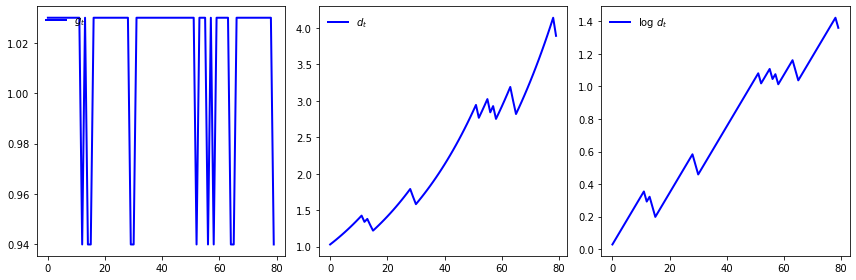

In [18]:
series = [ g_series, d_series, np.log(d_series)]
labels = ['$g_t$', '$d_t$', r'$\log \, d_t$']

fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, s, label in zip(axes.flatten(), series, labels):
    ax.plot(s, 'b-', lw=2, label=label)
    ax.legend(loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

## Modelling Asset Pricing

In [19]:
from numpy.linalg import eigvals, solve

In [20]:
class AssetPriceModel:
    """
    A class that stores the primitives of the asset pricing model.

    Parameters
    ----------
    β : scalar, float
        Discount factor
    mc : MarkovChain
        Contains the transition matrix and set of state values for the state
        process
    γ : scalar(float)
        Coefficient of risk aversion
    g : callable
        The function mapping states to growth rates

    """
    def __init__(self, β=0.96, mc=None, γ=1.5, g=lambda x: x):
        self.β, self.γ = β, γ
        self.g = g
        self.mc = mc
        self.n = self.mc.P.shape[0]

    def test_stability(self, Q):
        """
        Stability test for a given matrix Q.
        """
        sr = np.max(np.abs(eigvals(Q)))
        if not sr < 1 / self.β:
            msg = f"Spectral radius condition failed with radius = {sr}"
            raise ValueError(msg)

In [21]:
def tree_price(ap):
    """
    Computes the price-dividend ratio of the Lucas tree.

    Parameters
    ----------
    ap: AssetPriceModel
        An instance of AssetPriceModel containing primitives

    Returns
    -------
    v : array_like(float)
        Lucas tree price-dividend ratio

    """
    # Simplify names, set up matrices
    β, γ, P, y = ap.β, ap.γ, ap.mc.P, ap.mc.state_values
    J = P * ap.g(y)**(1 - γ)

    # Make sure that a unique solution exists
    ap.test_stability(J)

    # Compute v
    I = np.identity(ap.n)
    Ones = np.ones(ap.n)
    v = solve(I - β * J, β * J @ Ones)

    return v

In [22]:
ap = AssetPriceModel(mc=mc, γ=0)
v = tree_price(ap)

In [23]:
v

array([36.01765747, 35.23712115])

In [24]:
state_ids = np.where(g_series>1,1,0) # 0: negative dividend pgrowth, 1: positive growth

In [25]:
v_series = np.where(state_ids, v[0], v[1])

In [26]:
p_series = v_series * d_series

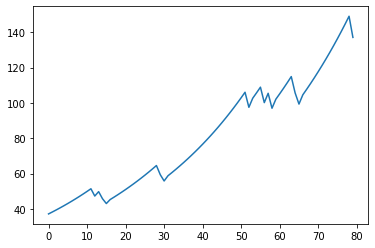

In [27]:
plt.plot(p_series)